In [119]:
import ngsolve as ngs
from ngsolve.webgui import Draw
import numpy as np

mesh = ngs.Mesh('proximity_geo.vol')
mesh.Curve(2)
mesh.RefineHP(3,factor = 0.2)
# mesh.Refine()
# mesh.Refine()

In [124]:
# Parameters

circ_mass = np.pi*0.031**2
circ_number = 58

mu0 = 1.256*1e-6
mu_iron = 1000*mu0
sigma = 58*1e6
J = 1e7
eps = 1e-10
order = 2

circles_left = ""; 
for i in range(58): circles_left+="circle_left_"+str(i)+"|"
circles_right = ""; 
for i in range(58): circles_right+="circle_right_"+str(i)+"|"

cf_Js = mesh.MaterialCF({circles_left: J, circles_right: -J}, default = 0)
cf_mu = mesh.MaterialCF({ circles_left + circles_right + "left|right|bridge" : mu0, "ambient": mu_iron})
cf_sigma = mesh.MaterialCF({circles_left + circles_right: sigma}, default = 0)

#############################################################################################################

f = 50 #(Hz)
w = f*2*np.pi

H1_A = ngs.H1(mesh, order = order, dirichlet = "ambient_face", complex = True)
# L2_L = ngs.H1(mesh, order = order, definedon = circles_left + circles_right, complex = True)
# HDiv_U = ngs.VectorL2(mesh, order = order-1, definedon = circles_left + circles_right, complex = True)

L2_L = ngs.L2(mesh, order = order, definedon = circles_left + circles_right, complex = True)
HDiv_U = ngs.HDiv(mesh, order = order, dirichlet = "circle_edge", definedon = circles_left + circles_right, complex = True, RT = True)
# HDiv_U = ngs.HDiv(mesh, order = order, dirichlet = "circle_edge", definedon = circles_left + circles_right, complex = True)


X = H1_A*L2_L*HDiv_U

(A,L,U), (As,Ls,Us) = X.TnT()

K = ngs.BilinearForm(X)
K += (1/cf_mu*ngs.grad(A)*ngs.grad(As))*ngs.dx +((1j*w)*cf_sigma*(A+L)*As +ngs.div(U)*As)*ngs.dx(circles_left + circles_right)\
    +((1j*w)*cf_sigma*(A*Ls + L*Ls) + ngs.div(U)*Ls)*ngs.dx(circles_left + circles_right)\
    +(L*ngs.div(Us) + eps*U*Us + 0*A*ngs.div(Us))*ngs.dx(circles_left + circles_right)\
# K += (1/cf_mu*ngs.grad(A)*ngs.grad(As))*ngs.dx +((1j*w)*cf_sigma*(A+L)*As + U*ngs.grad(As))*ngs.dx(circles_left + circles_right)\
#     +((1j*w)*cf_sigma*(A*Ls + L*Ls) + U*ngs.grad(Ls))*ngs.dx(circles_left + circles_right)\
#     +(Us*ngs.grad(L)+eps*U*Us)*ngs.dx(circles_left + circles_right)\
        
K.Assemble()

# rows,cols,vals = K.mat.COO()
# import scipy.sparse as sp
# A = sp.csr_matrix((vals,(rows,cols)))
# import matplotlib.pylab as plt
# plt.spy(A, markersize = 1)

f = ngs.LinearForm(X)
f += (cf_Js*Ls)*ngs.dx(circles_left + circles_right)
# f += (cf_Js*v)*ngs.dx() + ((1-cf_Js)*q)*ngs.dx("circle_left|circle_right")
f.Assemble()


ALU = ngs.GridFunction(X)
ALU.vec.data += K.mat.Inverse(X.FreeDofs())*f.vec

A = ALU.components[0]
L = ALU.components[1]
U = ALU.components[2]

B = ngs.grad(A)

J = (1j*w)*cf_sigma*(A+L)#+ngs.div(U)

# # J = J/intJ*I

In [125]:
Draw(ngs.log(ngs.Norm(J)), mesh, settings = {"Objects": {"Wireframe": False}})
Draw(ngs.log(ngs.Norm(L)), mesh, settings = {"Objects": {"Wireframe": False}})

WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'gui_settings': {'Objects': {'Wireframe': Fal…

WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'gui_settings': {'Objects': {'Wireframe': Fal…

BaseWebGuiScene

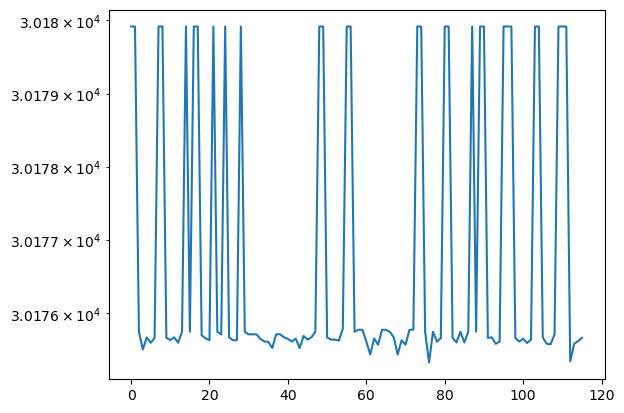

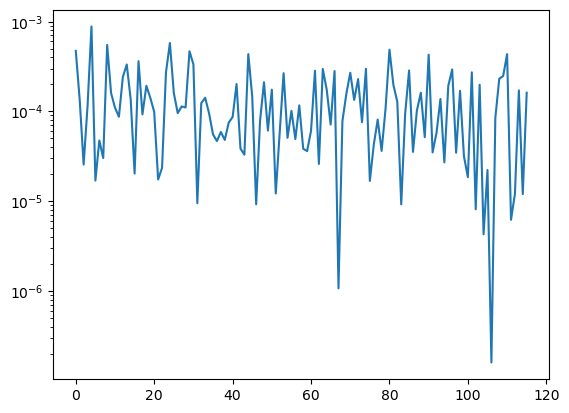

In [121]:
int = []
for i in range(58):
    int.append(ngs.Integrate(J*ngs.dx("circle_left_"+str(i)), mesh))
for i in range(58):
    int.append(ngs.Integrate(J*ngs.dx("circle_right_"+str(i)), mesh))
# mesh.nv

plt.semilogy(abs(np.real(int)))
plt.figure()
plt.semilogy(abs(np.imag(int)))

# ngs.Integrate(1/eps*ngs.grad(L)*ngs.grad(A), mesh)

In [122]:
print(np.array(X.FreeDofs()).shape)
print(np.where(np.array(X.FreeDofs()))[0].shape)

(369645,)
(303271,)


In [123]:
help(ngs.NumberSpace)

Help on class NumberSpace in module ngsolve.comp:

class NumberSpace(FESpace)
 |  Keyword arguments can be:
 |  
 |  order: int = 1
 |    order of finite element space
 |  complex: bool = False
 |    Set if FESpace should be complex
 |  dirichlet: regexpr
 |    Regular expression string defining the dirichlet boundary.
 |    More than one boundary can be combined by the | operator,
 |    i.e.: dirichlet = 'top|right'
 |  dirichlet_bbnd: regexpr
 |    Regular expression string defining the dirichlet bboundary,
 |    i.e. points in 2D and edges in 3D.
 |    More than one boundary can be combined by the | operator,
 |    i.e.: dirichlet_bbnd = 'top|right'
 |  dirichlet_bbbnd: regexpr
 |    Regular expression string defining the dirichlet bbboundary,
 |    i.e. points in 3D.
 |    More than one boundary can be combined by the | operator,
 |    i.e.: dirichlet_bbbnd = 'top|right'
 |  definedon: Region or regexpr
 |    FESpace is only defined on specific Region, created with mesh.Materials('